In [16]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from dython.nominal import associations

In [2]:
df = pd.read_csv("../data/mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
del df["veil-type"]

In [4]:
df.shape[1]

22

In [5]:
df.nunique().sort_values()

class                        2
gill-size                    2
gill-spacing                 2
gill-attachment              2
stalk-shape                  2
bruises                      2
ring-number                  3
stalk-surface-below-ring     4
cap-surface                  4
stalk-surface-above-ring     4
veil-color                   4
ring-type                    5
stalk-root                   5
cap-shape                    6
population                   6
habitat                      7
stalk-color-above-ring       9
spore-print-color            9
stalk-color-below-ring       9
odor                         9
cap-color                   10
gill-color                  12
dtype: int64

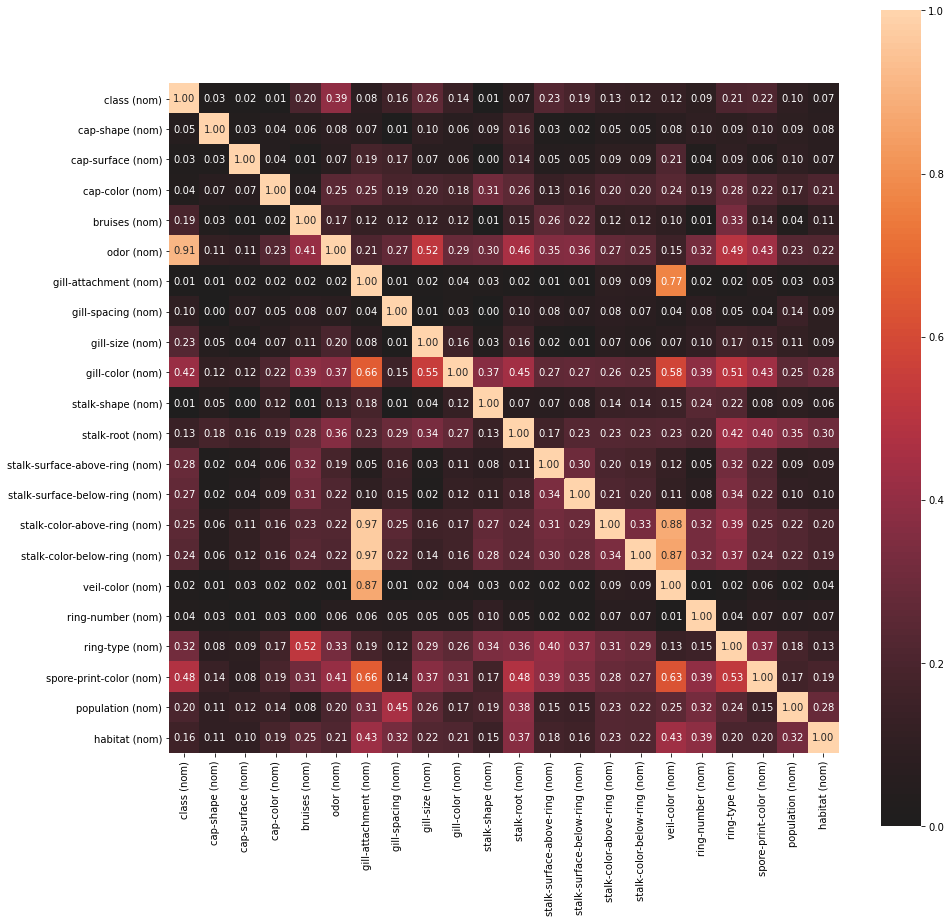

In [23]:
associations(df, theil_u=True, figsize=(15, 15), mark_columns=True);

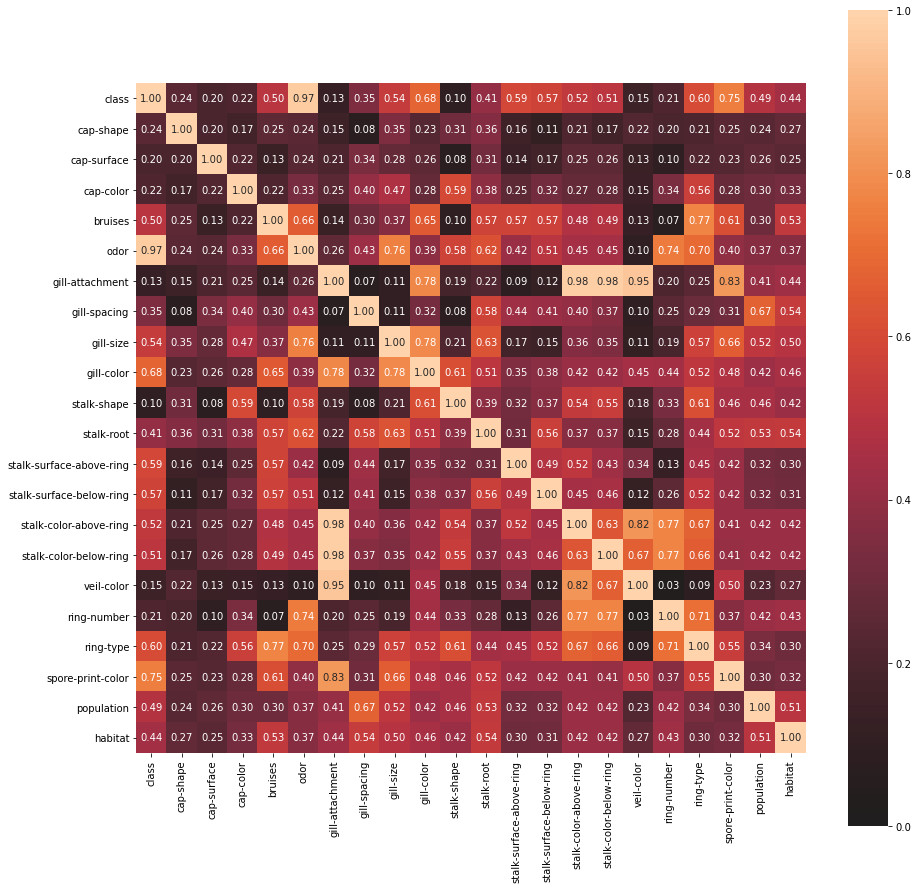

In [21]:
associations(df, figsize=(15, 15));

In [6]:
df_oh = pd.get_dummies(df)
df_oh.head()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


<AxesSubplot:>

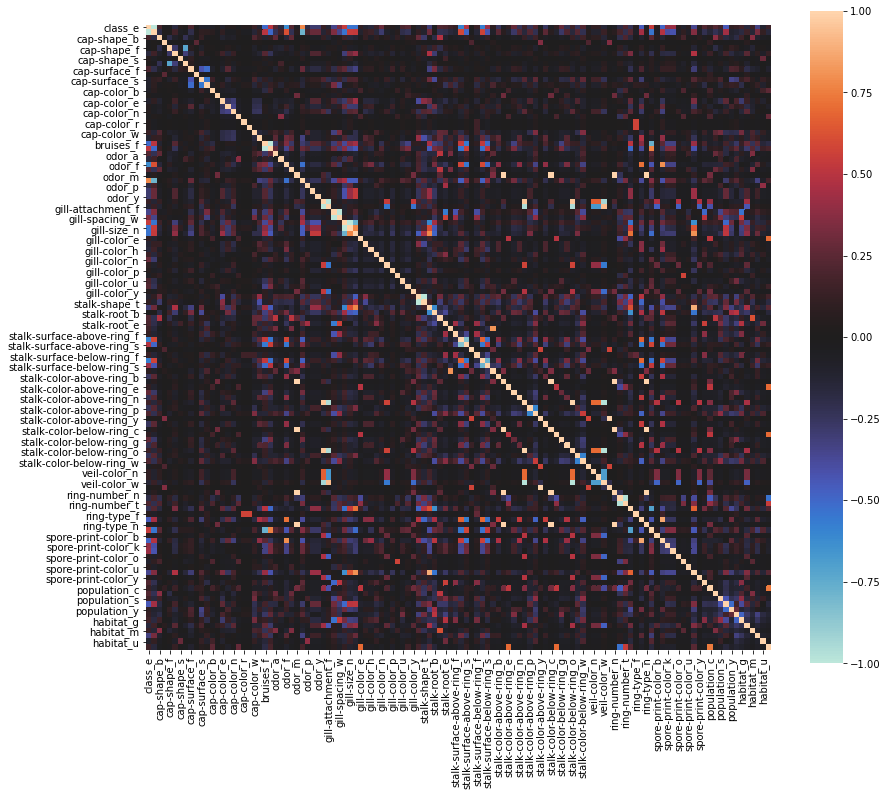

In [7]:
plt.figure(figsize=(14,12))
sb.heatmap(df_oh.corr(), center=0, square=True)

In [8]:
df_oh.shape[1]

118

/usr/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


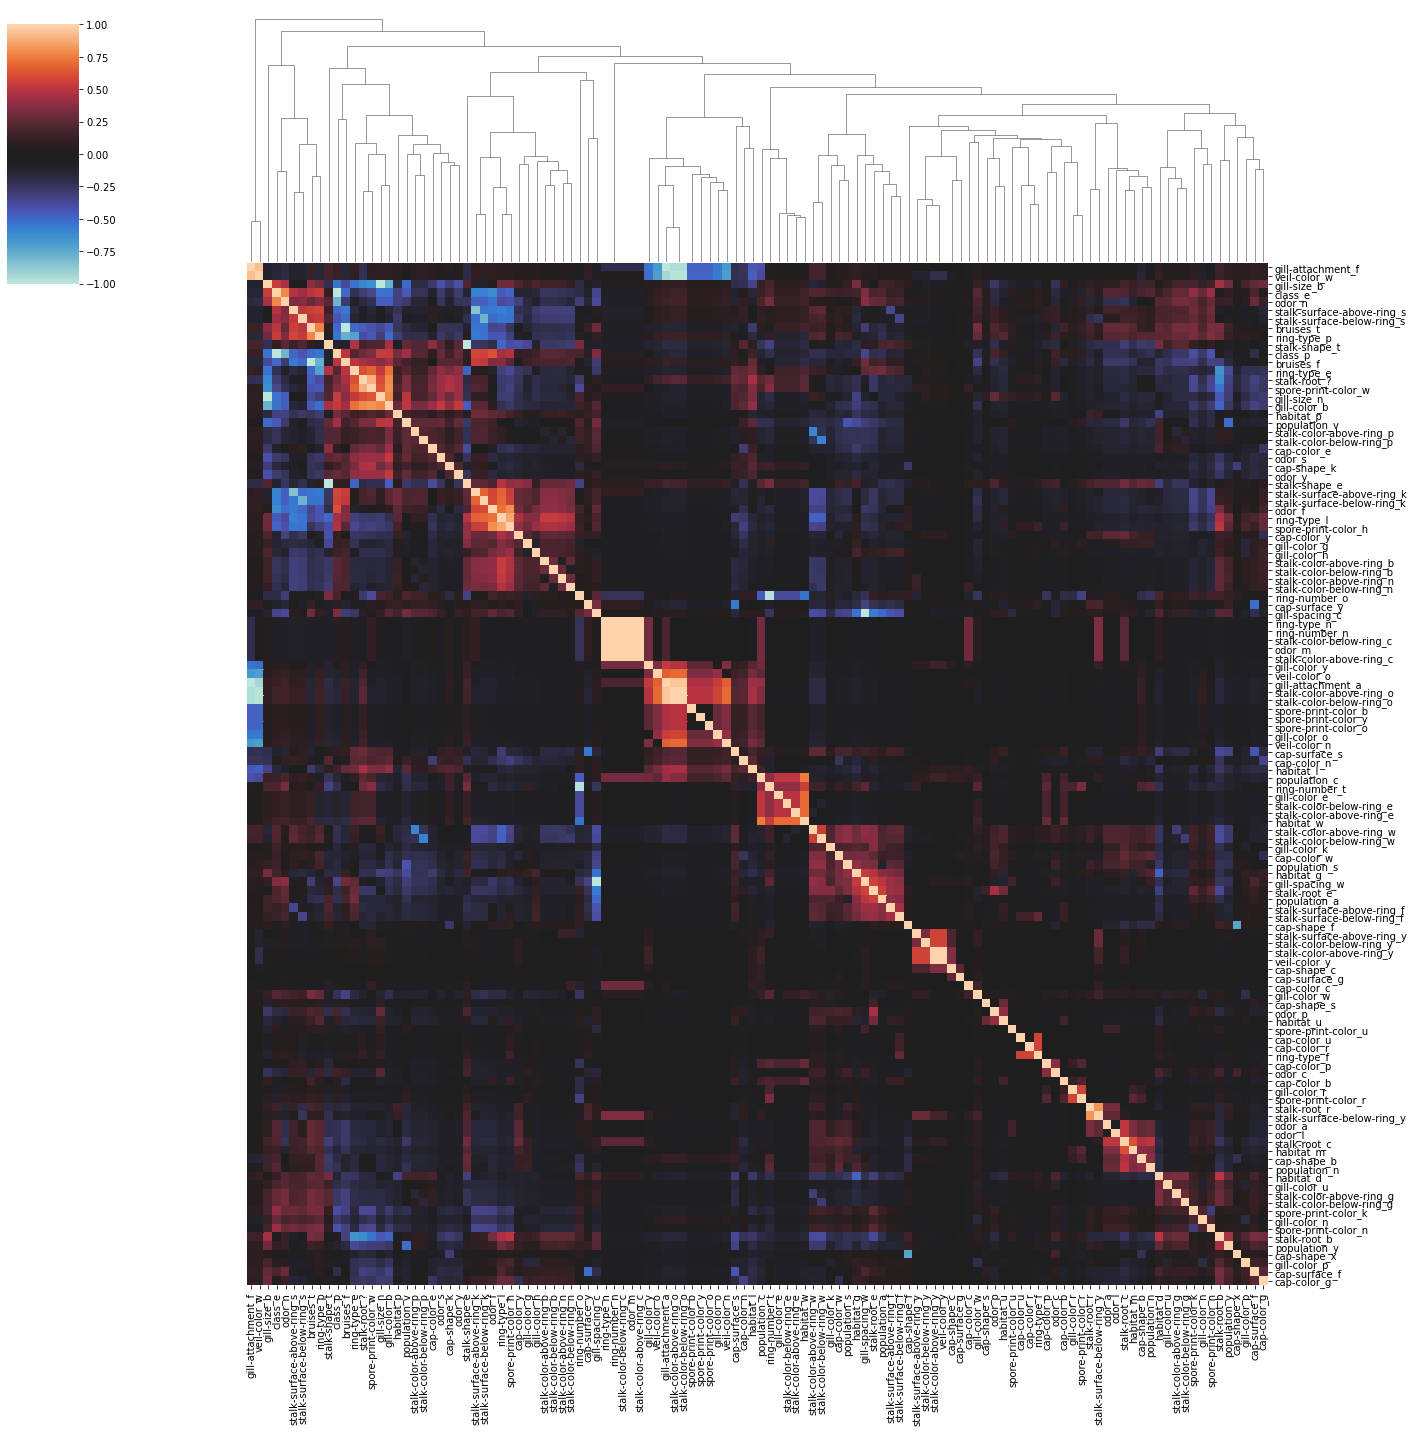

In [9]:
cg = sb.clustermap(df_oh.corr(),
        method='average',   # "single" "complete"
        metric='euclidean', # "correlation"
        xticklabels=True,   # Show all x lables
        yticklabels=True,   # Show all y lables
        center=0,           # For correct colormap
        figsize=(20,20))    #  cmap="vlag"

cg.ax_row_dendrogram.set_visible(False)
#cg.ax_col_dendrogram.set_visible(False)

In [10]:
import scipy.stats as ss

In [15]:
# Categorical vs Categorical (Symetric)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Categorical vs Categorical (No Symetric)
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
# Categorical vs Numerical
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def conditional_entropy(x,
                        y,
                        nan_strategy=REPLACE,
                        nan_replace_value=DEFAULT_REPLACE_VALUE):

    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy)
    return entropy

NameError: name 'REPLACE' is not defined

In [12]:
cramers_v(df["class"], df["cap-shape"])

0.24432985008184127

In [13]:
def custom_corr(df, fn):

    rows = []

    for var1 in df:
        col = []
        for var2 in df :
            value = fn(df[var1], df[var2]) # Cramer's V test
            col.append(value)  
        rows.append(col)

    return pd.DataFrame(np.array(rows), columns=df.columns, index=df.columns)



df_cramers_v = custom_corr(df, cramers_v)

In [14]:
df_theils_u = custom_corr(df, theils_u)

NameError: name 'conditional_entropy' is not defined

<AxesSubplot:>

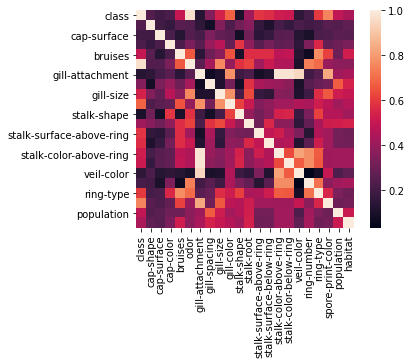

In [30]:
sb.heatmap(df_cat, square=True)

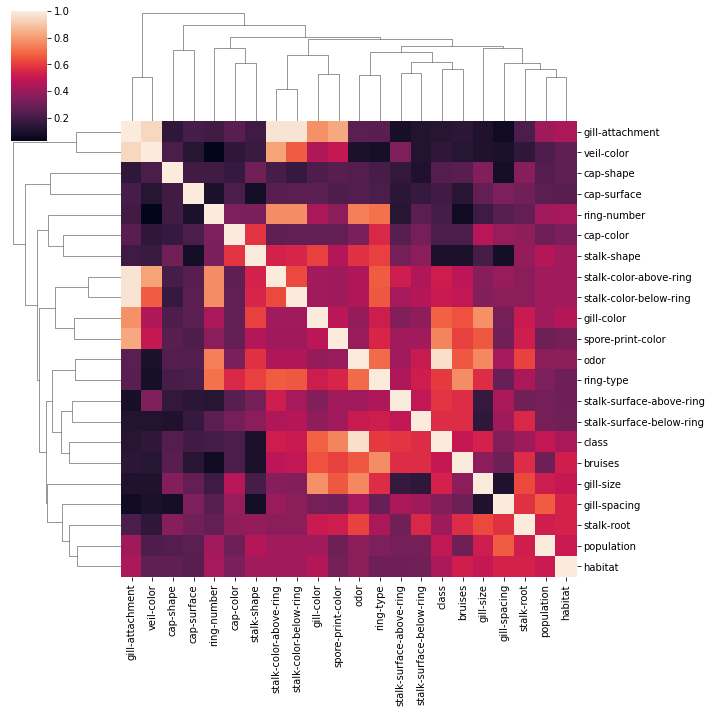

In [35]:
cg = sb.clustermap(df_cat,
        method='average',   # "average" "single" "complete"
        metric='euclidean', # "correlation"
        xticklabels=True,   # Show all x lables
        yticklabels=True,   # Show all y lables
        figsize=(10,10))    #  cmap="vlag"